In [1]:
## Reload the modules each time there are modified
%load_ext autoreload
%autoreload 2

In [13]:
import numpy as np
import matplotlib.pyplot as plt

from src.utils import print_loading
from src.arms import Bernoulli
from src.stochastic_bandit import MAB, BernoulliMAB
from src.multiplayers import MultiplayerEnv, PlayerRandTop, PlayerMCTop, UCB1Policy, KlUCBPolicy

In [14]:
BernoulliMAB([0.5, 0.2, 0.8, 0.6, 0.3, 0.35, 0.7]).m_worst_arms_means(3)

array([0.5 , 0.35, 0.3 , 0.2 ])

In [17]:
bandit = BernoulliMAB([0.2, 0.3, 0.5, 0.75, 0.8])
K, M = bandit.nb_arms, 3
policy = UCB1Policy(alpha=0.5)
players = [PlayerMCTop(K, M, policy) for _ in range(M)]

In [46]:
time_horizon = 2000
T = np.arange(1, time_horizon + 1)
env = MultiplayerEnv(bandit, players, time_horizon)

In [76]:
N_exp = 250
avg_cum_reward = np.zeros(time_horizon)
avg_nb_colliding_players = np.zeros((K, time_horizon))
avg_nb_selections = np.zeros((K, time_horizon))
end_regrets = np.zeros(N_exp)

oracle_cum_reward = bandit.m_best_arms_means(M).sum() * T

for i in range(N_exp):
    env.clear()
    env.run()
    avg_cum_reward += env.cumulative_reward()
    for k in range(K):
        avg_nb_colliding_players[k] += env.cumulative_nb_of_colliding_players(k)
        avg_nb_selections[k] += env.cumulative_nb_of_selections(k)
    print_loading(i+1, N_exp)
    end_regrets[i] = oracle_cum_reward[-1] - env.cumulative_reward()[-1]

avg_cum_reward /= N_exp
avg_nb_colliding_players /= N_exp
avg_nb_selections /= N_exp

# Compute the expected regret using the regret definition
cum_regret = oracle_cum_reward - avg_cum_reward

# Compute the expected regret using the regret decomposition formula
gaps = (bandit.means - bandit.last_best_arm_mean(M))[:, np.newaxis]
decomp_c = (bandit.means[:, np.newaxis] * avg_nb_colliding_players).sum(0)
decomp_ab = np.where(gaps < 0,  - gaps * avg_nb_selections, gaps * (T - avg_nb_selections)).sum(0)
cum_regret2 = decomp_ab + decomp_c

250/250 [====================] (100%)

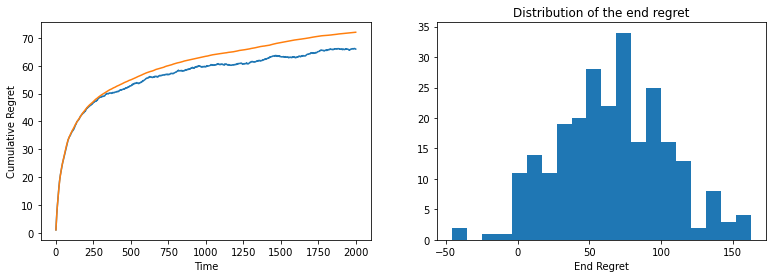

In [77]:
plt.figure(figsize=(13, 4))
plt.subplot(121)
plt.plot(cum_regret)
plt.plot(cum_regret2)
plt.xlabel("Time")
plt.ylabel("Cumulative Regret")

plt.subplot(122)
plt.hist(end_regrets, bins=20)
plt.title("Distribution of the end regret")
plt.xlabel("End Regret")
plt.show()

In [10]:
banditA = BernoulliMAB([0.45, 0.5, 0.6])
banditB = BernoulliMAB([0.1, 0.05, 0.02, 0.01])

K, M = banditA.nb_arms, 1
kl_ucb_policy = KlUCBPolicy(arms_types=banditA.arms)
players = [PlayerMCTop(K, M, kl_ucb_policy) for _ in range(M)]

selections, collisions, chair , sensing_infos = multiplayer_env(banditA, players, 100)

In [11]:
rewards = sensing_infos * (~ collisions)

In [15]:
 L = [1, 2, 4, 5, 6, 7, 8, 9]
 c = np.array([False, False, False, True, False, True, True, False])
 np.where(~c, L, 0), ~c * L

(array([1, 2, 4, 0, 6, 0, 0, 9]), array([1, 2, 4, 0, 6, 0, 0, 9]))